# Imports: 

In [31]:
import pandas as pd
import os
import re

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, MolToFile
from rdkit.Chem import Draw

import json

import umap
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
cols = sns.color_palette()

import numpy as np
from rdkit.Chem import AllChem

import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

import holoviews as hv 
import bokeh.io
import bokeh.plotting
import colorcet as cc

import hvplot.pandas

import random

import pandas as pd
import numpy as np
import sys
sys.path.append('/home/ajinich/Documents/repos/pySankey')
from pysankey import sankey

Populating the interactive namespace from numpy and matplotlib


/home/ajinich/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Functions

In [2]:
def choose_k(data, max_clus):
    "Helper function to choose the number of clusters for KMeans."
    
    k_tests = np.arange(2, max_clus)
    wcss = []
    silhouettes_ = []
    for k in tqdm.tqdm(k_tests): 
        clustering = KMeans(k, random_state= 42).fit(data)
        wcss.append(clustering.inertia_)
        silhouettes_.append(silhouette_score(data, clustering.predict(data)))
    
    
    return wcss, silhouettes_

# Data: 

File source: UP_Rhea_to_smiles.ipynb

In [3]:
file_in = '../../data/mohammed/UP45_Rhea_ChEBI_smiles.csv'
df_45_l_rhea_chebi_smiles = pd.read_csv( file_in )
print(df_45_l_rhea_chebi_smiles.shape)
df_45_l_rhea_chebi_smiles.head(3)

(5153, 5)


,Entry,RheaID,type,ChEBI,smiles
0,A0A024R7X6,25033,LEFT,CHEBI_58349,NC(=O)c1ccc[n+](c1)[C@@H]1O[C@H](COP([O-])(=O)...
1,A0A024R7X6,25033,LEFT,CHEBI_17336,CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C/CO
2,A0A024R7X6,25033,RIGHT,CHEBI_15378,[H+]


Cofactors that I might want to remove: NADH, H+, NAD, NADP, NADPH, CO2

[PENDING]: Others: phosphate, orthophosphate? 

In [4]:
df_45_l_rhea_chebi_smiles.Entry.value_counts().head(10)

O70351    90
O08756    90
Q99714    90
O02691    90
Q9QYF1    70
Q8VCC1    65
P70684    65
P15428    65
P0AEK2    65
Q8MJY8    65
Name: Entry, dtype: int64

In [5]:
cofactor_IDS = ['CHEBI_57945', 'CHEBI_15378', 'CHEBI_57540', 'CHEBI_58349', 'CHEBI_57783', 'CHEBI_16526']

Reactions with NAD/NADH vs. NADP/NADPH

In [6]:
nad_nadh = ['CHEBI_57540', 'CHEBI_57945']
nadp_nadph = ['CHEBI_58349', 'CHEBI_57783']
# NAD/NADH: 
df_45_l_rhea_chebi_smiles_NAD = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(nad_nadh)].copy()
list_UP_NAD = df_45_l_rhea_chebi_smiles_NAD.Entry.unique()

# NADP/NADPH: 
df_45_l_rhea_chebi_smiles_NADP = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(nadp_nadph)].copy()
list_UP_NADP = df_45_l_rhea_chebi_smiles_NADP.Entry.unique()

# UP_enzymes using both cofactors: 
list_UP_NAD_NADP = list(set(list_UP_NAD).intersection(set(list_UP_NADP)))
# using only NAD
list_UP_NAD_only = list(set(list_UP_NAD) - set(list_UP_NADP))
# using only NADP
list_UP_NADP_only = list(set(list_UP_NADP) - set(list_UP_NAD))

In [7]:
print(len(list_UP_NAD_NADP), len(list_UP_NAD_only), len(list_UP_NADP_only))

51 98 205


Reactions involving CO2: 

In [8]:
co2 = ['CHEBI_16526']
df_45_l_rhea_chebi_smiles_CO2 = df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(co2)].copy()
list_CO2 = df_45_l_rhea_chebi_smiles_CO2.Entry.unique()
list_CO2

array(['A0A0Q7MGL0', 'A0A4R4NN60', 'A0A4R4VUE8', 'A0A4R4WS15',
       'A0A5R8P1W5', 'A0A6L7ELE1', 'P39831', 'Q05016', 'Q9KWN1'],
      dtype=object)

remove cofactors: 

In [9]:
df_45_l_rhea_chebi_smiles_noCF = df_45_l_rhea_chebi_smiles[~df_45_l_rhea_chebi_smiles.ChEBI.isin(cofactor_IDS)].copy()
df_45_l_rhea_chebi_smiles_noCF.reset_index(inplace=True, drop=True)

In [10]:
# How many uniqu compounds? 
print(df_45_l_rhea_chebi_smiles_noCF.smiles.unique().shape)
# How many come from the left side of the reaction? 
print(df_45_l_rhea_chebi_smiles_noCF[df_45_l_rhea_chebi_smiles_noCF.type=='LEFT'].smiles.unique().shape)
# How many come from the right side of the reaction? 
print(df_45_l_rhea_chebi_smiles_noCF[df_45_l_rhea_chebi_smiles_noCF.type=='RIGHT'].smiles.unique().shape)

(421,)
(224,)
(216,)


### Visualize a random subset of the substrate/product SMILES strings : 

In [1]:
mols_smiles = list(set(df_45_l_rhea_chebi_smiles_noCF.smiles.tolist()))
mols_rdkit = [Chem.MolFromSmiles(smi) for smi in mols_smiles]
rand_mols = random.sample(mols_rdkit, 5)
for mol in rand_mols:
    display(mol)


NameError: name 'df_45_l_rhea_chebi_smiles_noCF' is not defined

## Compute their Morgan fingerprints and cluster them: 

In [12]:
df_mols_uniq_noCF = df_45_l_rhea_chebi_smiles_noCF[['ChEBI', 'smiles']].drop_duplicates()
df_mols_uniq_noCF.reset_index(inplace=True, drop=True)
mols_smiles = df_mols_uniq_noCF.smiles.tolist()

Xfp = []
for smi in mols_smiles:
    mol = Chem.MolFromSmiles(smi)
    Xfp.append(np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=3)))
Xfp = np.stack(Xfp, 0)

In [13]:
Xfp[0,:]

array([0, 0, 0, ..., 0, 0, 0])

#### UMAP projection of Morgan fingerprints: 

In [14]:
seed = 184
np.random.seed(seed)
u_fp = umap.UMAP(random_state = seed, metric='jaccard', min_dist = 0, n_components = 3).fit_transform(Xfp)

/home/ajinich/miniconda3/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


#### Add UMAP coordinates to compound dataframe

In [15]:
df_mols_uniq_noCF['u1'], df_mols_uniq_noCF['u2'], df_mols_uniq_noCF['u3'] = u_fp[:,0], u_fp[:,1], u_fp[:,2]
df_mols_uniq_noCF.head(2)

,ChEBI,smiles,u1,u2,u3
0,CHEBI_17336,CC(\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C)=C/CO,8.082915,-0.934974,12.310073
1,CHEBI_17898,[H]C(=O)\C=C(C)\C=C\C=C(C)\C=C\C1=C(C)CCCC1(C)C,8.071352,-0.950501,12.321568


In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/ajinich/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


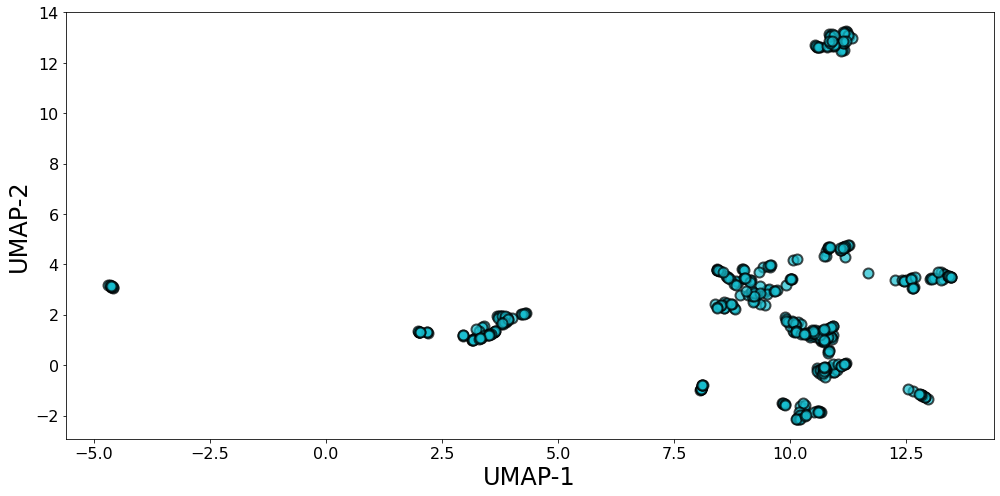

In [17]:
plt.figure(figsize=(14,7))

plt.scatter(df_mols_uniq_noCF['u1'], df_mols_uniq_noCF['u2'], s = 100, color = cols[-1], edgecolors='k', linewidths = 2, alpha = 0.7)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

plt.tight_layout()

### Cluster the compounds according to UMAP coordinates 

#### (should capture molecular structure): 

In [18]:
data = df_mols_uniq_noCF[['u1', 'u2', 'u3']].values

In [19]:
%%time
wcss, sil = choose_k(data, max_clus = 40)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:03<00:00, 12.23it/s]

CPU times: user 24.5 s, sys: 244 ms, total: 24.7 s
Wall time: 3.11 s


In [20]:
wcss_plot = hv.Curve((wcss), label="Within cluster sum of squares").opts(
    xlabel="number of clusters",
    ylabel="WCSS",
    padding=0.1,
    tools=["hover"],
    color="orange",
)
silhouette_plot = hv.Curve((sil), label="silhouette score").opts(
    xlabel="number of clusters", ylabel="silhouette score", padding=0.1, tools=["hover"]
)

wcss_plot + silhouette_plot.opts(shared_axes = False)

:Layout
   .Curve.Within_cluster_sum_of_squares :Curve   [x]   (y)
   .Curve.Silhouette_score              :Curve   [x]   (y)

### Choose the optimal number of clusters and visualize:

In [21]:
seed = 43
np.random.seed(seed)

num_clus = 15
clustering = KMeans(n_clusters = num_clus, random_state= seed).fit(data)
cluster_labels = clustering.labels_

df_mols_uniq_noCF['cluster_labels'] = cluster_labels

In [48]:
df_mols_uniq_noCF.hvplot.scatter(x="u1", y="u2", padding=0.05, width = 1000, height = 600, size = 55, alpha = 0.7, 
                     hover_cols=['ChEBI'], line_color='k', c = 'cluster_labels', clabel = 'clusters', cmap = cc.glasbey[:num_clus])


:Scatter   [u1]   (u2,cluster_labels,ChEBI)

In [ ]:
plt.figure(figsize=(6,6))
for clus in df_mols_uniq_noCF.cluster_labels.unique():
    df_clus = df_mols_uniq_noCF[df_mols_uniq_noCF.cluster_labels==clus]
    xdata = df_clus.u1
    ydata = df_clus.u2
    plt.scatter(xdata, ydata, s=200, edgecolors='k', alpha=0.6)
plt.xlabel('UMAP x-coordinate', fontsize = 16)
yl = plt.ylabel('UMAP y-coordinate', fontsize = 16)
plt.tight_layout()
path_out = '../../figs/mohammed/mol_images/clustering.png'
plt.savefig(path_out, dpi=300)

# Visualize compounds from each of these clusters to understand who they are: 

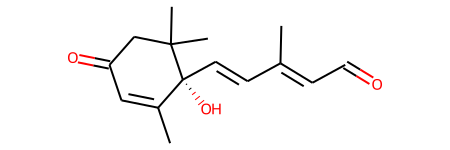

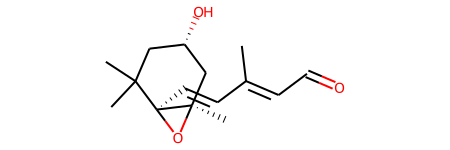

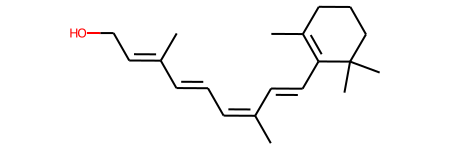

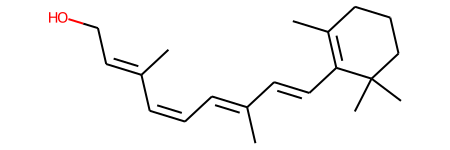

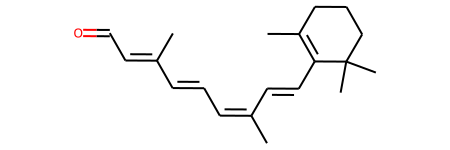

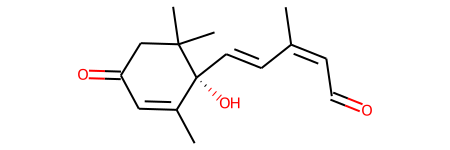

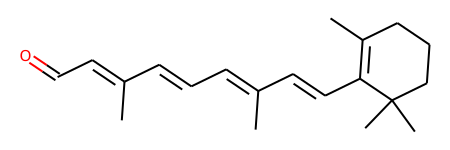

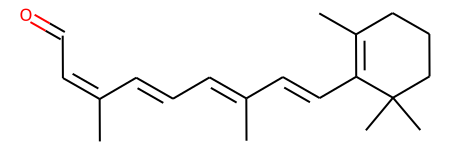

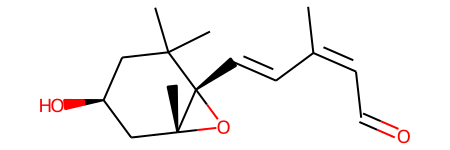

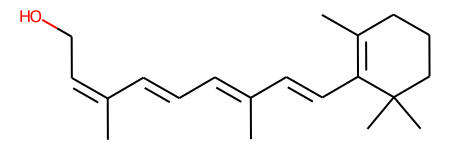

In [71]:
clus_num = 8
df_clus = df_mols_uniq_noCF[df_mols_uniq_noCF.cluster_labels.values == clus_num].copy()

df_sample = df_clus.sample(10)
smi_list = df_sample.smiles.tolist()
smi_list = list(set(smi_list))
chebi_list = df_sample.ChEBI.tolist()
rand_mols = [Chem.MolFromSmiles(smi) for smi in smi_list]

# Draw.MolsToGridImage(mols_rdkit, subImgSize=(1000,1000), molsPerRow=3)
for mol in rand_mols:
    display(mol)

In [65]:
df_45_l_rhea_chebi_smiles[df_45_l_rhea_chebi_smiles.ChEBI.isin(df_sample.ChEBI)].sample(5)

,Entry,RheaID,type,ChEBI,smiles
424,G3YG17,17025,RIGHT,CHEBI_17399,OC[C@H](O)[C@@H](O)C(=O)CO
2836,Q1MLL4,20685,LEFT,CHEBI_16813,OC[C@H](O)[C@@H](O)[C@@H](O)[C@H](O)CO
2650,P87219,14609,LEFT,CHEBI_17924,OC[C@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
4005,Q8JIS3,18005,LEFT,CHEBI_48300,OC[C@@H](O)[C@H](O)CO
4003,Q8JIS3,17025,RIGHT,CHEBI_17399,OC[C@H](O)[C@@H](O)C(=O)CO


### Make a dataframe to train a classifier on: 

In [63]:
# Grab all compounds in the cluster(s) of interest:
list_clus = [3,9]
df_clus = df_mols_uniq_noCF[df_mols_uniq_noCF.cluster_labels.isin(list_clus)].copy()
print(df_clus.shape)

# Grab all proteins/entries that have substrates in those clusters: 
entries_clus = df_45_l_rhea_chebi_smiles_noCF[df_45_l_rhea_chebi_smiles_noCF.ChEBI.isin(df_clus.ChEBI)].Entry.unique().tolist()
print(len(entries_clus))

(62, 6)
53


In [64]:
df_cluster_classify = pd.DataFrame()
df_cluster_classify['Entry'] = df_45_l_rhea_chebi_smiles.Entry.unique()
# enzymes that don't have substrates belonging to this cluster
df_cluster_classify.loc[~df_cluster_classify.Entry.isin(entries_clus), 'compound_cluster'] = 0
# enzymes that *do* have substrates belonging to this cluster
df_cluster_classify.loc[df_cluster_classify.Entry.isin(entries_clus), 'compound_cluster'] = 1

In [67]:
file_out = '../../data/mohammed/beta_keto_AA_cluster_classify.csv'
df_cluster_classify.to_csv(file_out, index = False)

# Sankey diagram: 
## mapping protein embedding clusters to compound clusters: 

In [114]:
file_in = '../../data/mohammed/protein_clusters.csv'
df_prot = pd.read_csv(file_in)
df_prot.rename(columns={'cluster_labels':'protein_cluster'}, inplace=True)
print(df_prot.shape)
df_prot.head(2)

(4325, 2)


,Entry,protein_cluster
0,Q9NZC7,4
1,Q99714,7


In [48]:
df_mol = df_mols_uniq_noCF[['ChEBI', 'cluster_labels']].copy()
df_mol.rename(columns={'cluster_labels':'mol_cluster'}, inplace=True)
df_mol.head(2)

,ChEBI,mol_cluster
0,CHEBI_17336,7
1,CHEBI_17898,7


In [49]:
df_mapping = df_45_l_rhea_chebi_smiles_noCF[['Entry', 'ChEBI']].copy()

df_mapping_1 = df_mapping.merge(df_prot, how = 'left', on = 'Entry')
df_mapping_2 = df_mapping_1.merge(df_mol, how = 'left', on = 'ChEBI')
df_for_river = df_mapping_2[['protein_cluster', 'mol_cluster']].copy()

# save to file:
file_out = '../../data/mohammed/river_plot_v3.csv'
df_for_river.to_csv(file_out, index = False)

Start here: 

In [51]:
file_in = '../../data/mohammed/river_plot_v3.csv'
df_for_river = pd.read_csv(file_in)
df_for_river.sort_values(by = 'protein_cluster', inplace=True)

In [75]:
df_for_river_nonan = df_for_river[~np.isnan(df_for_river.protein_cluster.values)].copy()

In [76]:
df_for_river_nonan['protein_cluster'] = [str(int(v)) for v in df_for_river_nonan['protein_cluster'].values]
df_for_river_nonan['mol_cluster'] = [str(int(v)) for v in df_for_river_nonan['mol_cluster'].values]

In [54]:
sankey(
    df_for_river_nonan['protein_cluster'], df_for_river_nonan['mol_cluster'], aspect=20,
    fontsize=8, figureName="sankey_diagram_ChEBI"
)

In [88]:
for prot_clus in df_for_river_nonan.protein_cluster.unique():
    df_test = df_for_river_nonan[df_for_river_nonan.protein_cluster.values == prot_clus]
    print('protein cluster:', prot_clus, ' <----> number of mol. clusters:', len(df_test.mol_cluster.unique()))

protein cluster: 0  <----> number of mol. clusters: 11
protein cluster: 1  <----> number of mol. clusters: 18
protein cluster: 2  <----> number of mol. clusters: 19
protein cluster: 3  <----> number of mol. clusters: 15
protein cluster: 4  <----> number of mol. clusters: 19
protein cluster: 5  <----> number of mol. clusters: 13
protein cluster: 6  <----> number of mol. clusters: 15
protein cluster: 7  <----> number of mol. clusters: 17


In [92]:
df_prot[df_prot.protein_cluster.values == 5]

,Entry,protein_cluster
8,P16152,5
41,Q9C826,5
67,P35270,5
80,P39831,5
82,P07914,5
...,...,...
4256,A0A3B3UXD7,5
4257,H9H0U9,5
4268,A0A3Q2PC26,5
4269,A0A165K181,5


# Some more analyses: 

### How promiscuous are individual enzymes? 

In other words... is it that:
1. many single enzymes tend to (promiscuously) catalyze compounds that are structurally very different? OR...
2. enzymes tend to catalyze compounds in a single cluster, but enzymes in the same emb-1 cluster will catalyze compounds in different molecular clusters.  

In [99]:
df_45_l_rhea_chebi_noCF_clust = df_45_l_rhea_chebi_smiles_noCF[['Entry', 'RheaID', 'ChEBI']].merge(df_mols_uniq_noCF[['ChEBI', 'cluster_labels']], 
                                                                  on = 'ChEBI', how = 'inner')

In [105]:
list_up_uniq = df_45_l_rhea_chebi_noCF_clust.Entry.unique()

In [107]:
list_num_clus = []
for entry in list_up_uniq:
    num_clus = len(df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.Entry.values == entry].cluster_labels.unique())
    list_num_clus.append(num_clus)

In [108]:
df_num_clus = pd.DataFrame()
df_num_clus['Entry'] = list_up_uniq
df_num_clus['num_clusters'] = list_num_clus 

In [111]:
df_num_clus['num_clusters'].value_counts()

1    220
2     94
3     19
4     17
5     11
Name: num_clusters, dtype: int64

In [152]:
df_num_clus[df_num_clus.num_clusters.values == 4].head(2)

,Entry,num_clusters
42,O14756,4
43,O54753,4


In [151]:
entry = 'O14756'
df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.Entry.values == entry].head(2)

,Entry,RheaID,ChEBI,cluster_labels
42,O14756,21284,CHEBI_17336,7
43,O14756,48488,CHEBI_17336,7


In [176]:
clus_num = 2
df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.cluster_labels.values == clus_num].sample(10)

,Entry,RheaID,ChEBI,cluster_labels
616,P28483,10740,CHEBI_17087,2
746,G5DGA8,45120,CHEBI_84966,2
1322,O14756,48488,CHEBI_83228,2
609,O75828,19257,CHEBI_17087,2
1831,P39831,43524,CHEBI_58320,2
467,A0A3Q8GLE8,61420,CHEBI_144481,2
1826,P39640,44628,CHEBI_84310,2
576,P26719,10736,CHEBI_17478,2
1738,P47727,63500,CHEBI_145547,2
1828,P39831,26438,CHEBI_33190,2


Sort the compounds in the given cluster by the number of "connections" to proteins: 

In [177]:
df_clus = df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.cluster_labels.values == clus_num].copy()

In [203]:
chebi = 'CHEBI_13705'
df_clus[df_clus.ChEBI.values == chebi].head()

,Entry,RheaID,ChEBI,cluster_labels
706,D4A1J4,20521,CHEBI_13705,2
707,P29147,20521,CHEBI_13705,2
708,Q02337,20521,CHEBI_13705,2
709,Q02338,20521,CHEBI_13705,2
710,Q561X9,20521,CHEBI_13705,2


In [189]:
df_clus.ChEBI.value_counts()

CHEBI_17087     26
CHEBI_83228     20
CHEBI_17478     10
CHEBI_13705      8
CHEBI_10983      8
CHEBI_145547     7
CHEBI_145544     7
CHEBI_15687      3
CHEBI_142593     3
CHEBI_144481     2
CHEBI_58585      2
CHEBI_84966      2
CHEBI_84970      2
CHEBI_16583      2
CHEBI_58320      2
CHEBI_28868      2
CHEBI_57552      1
CHEBI_131847     1
CHEBI_16812      1
CHEBI_33384      1
CHEBI_33855      1
CHEBI_61904      1
CHEBI_58213      1
CHEBI_16510      1
CHEBI_84310      1
CHEBI_35235      1
CHEBI_16016      1
CHEBI_142621     1
CHEBI_58371      1
CHEBI_58246      1
CHEBI_58458      1
CHEBI_84358      1
CHEBI_33190      1
Name: ChEBI, dtype: int64

### A more detailed version of this question would be: 

For enzymes where the substrates all belong to a single structural cluster (num_clusters == 1):

+ how many individual substrates are there? (promiscuity within a structural cluster)

## For each compound cluster, how many unique proteins have substrates in that cluster? 

In [165]:
list_clust = df_45_l_rhea_chebi_noCF_clust.cluster_labels.unique().tolist()
list_num_prots = []
for clust in list_clust:
    num_prots = df_45_l_rhea_chebi_noCF_clust[df_45_l_rhea_chebi_noCF_clust.cluster_labels.values == clust].Entry.unique().shape[0]
    list_num_prots.append(num_prots)
    
df_clust_count = pd.DataFrame()
df_clust_count['cluster'] = list_clust
df_clust_count['num_prots'] = list_num_prots


In [169]:
df_mols_uniq_noCF.hvplot.scatter(x="u1", y="u2", padding=0.05, width = 1000, height = 500, size = 55, alpha = 0.7, 
                     hover_cols=['ChEBI'], line_color='k', c = 'cluster_labels', clabel = 'clusters', cmap = cc.glasbey[:20])


:Scatter   [u1]   (u2,cluster_labels,ChEBI)

## This below is your best study guide! 

In [173]:
df_clust_count.sort_values(by = 'num_prots', ascending=False)

,cluster,num_prots
0,7,80
4,2,65
7,19,65
6,5,57
12,16,57
2,3,53
3,1,31
11,6,25
14,8,25
8,11,17


# OTHER: 

## Alternative ways to cluster the substrates: 

BSL: puedes usar hbdscan para el clustering

In [144]:
clustering = DBSCAN(eps=3, min_samples=2).fit(Xfp)
df_mols_uniq_noCF['dbscan_labels'] = clustering.labels_

In [145]:
df_mols_uniq_noCF.hvplot.scatter(x="u1", y="u2", padding=0.05, width = 1000, height = 500, size = 55, alpha = 0.7, 
                     hover_cols=['ChEBI'], line_color='k', c = 'dbscan_labels', clabel = 'clusters', 
                                 cmap = cc.glasbey[:len(set(clustering.labels_))])


:Scatter   [u1]   (u2,dbscan_labels,ChEBI)

In [146]:
df_mols_uniq_noCF['dbscan_labels'].value_counts().head(4)

-1     263
 5      27
 35      6
 19      6
Name: dbscan_labels, dtype: int64